In [209]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import StandardScaler

In [210]:
import sys
import os

# Get the current notebook's directory
notebook_dir = os.getcwd()

# Construct the relative path to the module
module_dir = os.path.join(notebook_dir, "..", "other_prediction_functions")

# Add to sys.path if not already included
if module_dir not in sys.path:
    sys.path.append(module_dir)

# Importing the module for transformer forecasting
import transformers_forecasting as tf  # type: ignore

In [211]:
## Parameters

# seed
my_seed = 42

# Hyperparameters
seq_length = 24  # Input sequence length
batch_size = 32
num_epochs = 100
learning_rate = 0.0001
horizon = 3  # Default prediction horizon (will vary later)

# Training / cross-validation split
training_fraction = 0.3  # Fraction of data used for training
cv_fraction = 0.6  # Fraction of data used for cross-validation (including training data)

# Model parameters
d_model = 16  # Embedding dimension
nhead = 2  # Number of heads in multi-head attention
num_layers = 2  # Number of transformer layers
dim_feedforward = 16  # Dimension of feedforward network
dropout = 0.5  # Dropout rate (now explicit)
final_layer_dim = None  # Dimension of the final hidden linear layer, None sets it to geometric mean of input and output

# Set device
selected_device = "cuda"  # choose between "cuda" or "cpu"

# input_sq_name = "artificial"  # noisy sinusoidal signal
# input_sq_name = "2. sq sl010 sag Xcs=125 3 cpts 2024 normalised"
# input_sq_name = "2020-11-10_KS81_Nav_Pur_1_3_cpts"
# input_sq_name = "2020-11-12_QN76_Nav_Pur_1_3_cpts"
# input_sq_name = "2020-11-17_CS31_Nav_Pur_2_3_cpts"
input_sq_name = "2020-11-17_JY02_Nav_Pur_2_3_cpts"
# input_sq_name = "2020-11-23_ON65_Nav_Pur_2_3_cpts"
# input_sq_name = "2020-11-23_PS11_Nav_Pur_1_3_cpts"
# input_sq_name = "2020-11-25_II29_Nav_Pur_1_3_cpts"
# input_sq_name = "2020-11-26_NE38_Nav_Pur_1_3_cpts"

In [212]:
# constants not to be changed
INPUT_SQ_DIR = "/mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences"
DATA_FN = "data.mat"

In [213]:
# Set random seeds for reproducibility
torch.manual_seed(my_seed)
np.random.seed(my_seed)

Using data from 2020-11-17_JY02_Nav_Pur_2_3_cpts


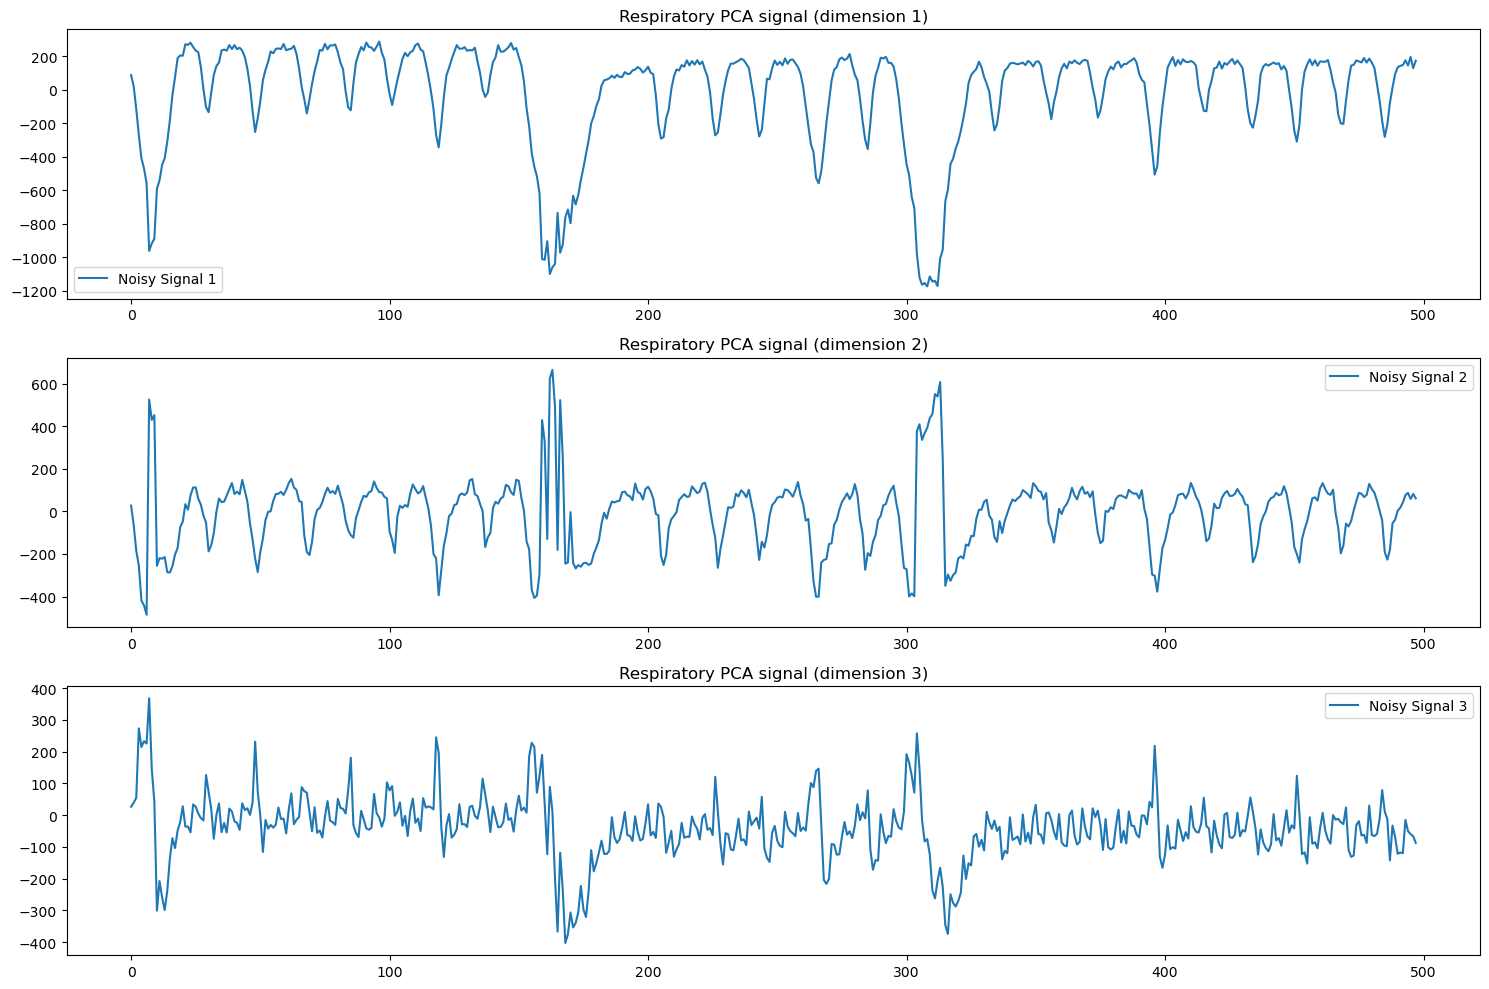

In [214]:
# Generating or loading time series data, and plotting it

if input_sq_name == "artificial":  # Generate data - n_features is the nb of dimensions in our multivariate time series
    n_features = 1
    n_samples = 1000
    noise_level = 0.3
    noisy_signals, clean_signals = tf.generate_multidimensional_sinusoids(
        n_samples=n_samples, n_features=n_features, noise_level=noise_level
    )

    # Plot the multidimensional data
    plt.figure(figsize=(15, 10))
    for i in range(n_features):
        plt.subplot(n_features, 1, i + 1)
        plt.plot(noisy_signals[i], label=f"Noisy Signal {i+1}")
        plt.plot(clean_signals[i], label=f"Clean Signal {i+1}")
        plt.legend()
        plt.title(f"Dimension {i+1}: Noisy vs Clean Sinusoidal Signal")
    plt.tight_layout()
    plt.show()

else:
    print(f"Using data from {input_sq_name}")

    # Getting the path of the file to load
    sq_filename = os.path.join(INPUT_SQ_DIR, input_sq_name, DATA_FN)

    # Actually getting the data
    time_data_mat = scipy.io.loadmat(sq_filename)
    noisy_signals = time_data_mat["org_data"]
    n_features, n_samples = noisy_signals.shape

    # Plot the multidimensional data
    plt.figure(figsize=(15, 10))
    for i in range(n_features):
        plt.subplot(n_features, 1, i + 1)
        plt.plot(noisy_signals[i], label=f"Noisy Signal {i+1}")
        plt.legend()
        plt.title(f"Respiratory PCA signal (dimension {i+1})")
    plt.tight_layout()
    plt.show()

In [215]:
# Data splitting - note that we keep the multidimensional structure
train_end = int(training_fraction * n_samples)
val_end = int(cv_fraction * n_samples)

train_data = noisy_signals[:, :train_end]
val_data = noisy_signals[:, train_end:val_end]
test_data = noisy_signals[:, val_end:]

# Use a single StandardScaler for all dimensions
# Reshape data for standardization, from [n_features, n_samples] to [n_samples, n_features]
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.T)
val_data_scaled = scaler.transform(val_data.T)
test_data_scaled = scaler.transform(test_data.T)

# Print statistics to verify standardization - reshape back to [n_features, n_samples] format
print(f"Training data mean: {np.mean(train_data_scaled):.6f}, std: {np.std(train_data_scaled.T):.6f}")
print(f"Validation data mean: {np.mean(val_data_scaled):.6f}, std: {np.std(val_data_scaled.T):.6f}")
print(f"Test data mean: {np.mean(test_data_scaled):.6f}, std: {np.std(test_data_scaled.T):.6f}")

Training data mean: 0.000000, std: 1.000000
Validation data mean: -0.505637, std: 1.284948
Test data mean: -0.362002, std: 1.159820


In [216]:
# Reshape back to [n_features, n_samples] format
train_data_scaled = train_data_scaled.T
val_data_scaled = val_data_scaled.T
test_data_scaled = test_data_scaled.T

# Create sequences - note the shape change to handle multiple dimensions
X_train, y_train, train_indices = tf.create_multidim_sequences(train_data_scaled, seq_length, horizon)
X_val, y_val, val_indices = tf.create_multidim_sequences(val_data_scaled, seq_length, horizon)
X_test, y_test, test_indices = tf.create_multidim_sequences(test_data_scaled, seq_length, horizon)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# Should show: X_train shape: (samples, seq_length, n_features), y_train shape: (samples, n_features)

print(f"Prediction horizon: {horizon} step(s) ahead")

# Convert to PyTorch tensors, and then dataloaders
train_loader = tf.get_data_loader(X_train, y_train, batch_size, shuffle=True)
val_loader = tf.get_data_loader(X_val, y_val, batch_size, shuffle=False)
test_loader = tf.get_data_loader(X_test, y_test, batch_size, shuffle=False)

X_train shape: (123, 24, 3), y_train shape: (123, 3)
Prediction horizon: 3 step(s) ahead


In [217]:
# Get the device
device = tf.get_device(selected_device)
print(f"Using device: {device}")

Using device: cuda


In [218]:
# Initialize the model and move it to the device
model = tf.MultiDimTimeSeriesTransformer(
    input_dim=n_features,  # Number of input features (dimensions)
    output_dim=n_features,  # Number of output features (dimensions)
    seq_length=seq_length,  # SHL
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    final_layer_dim=final_layer_dim,
    dropout=dropout,
).to(device)

In [219]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [220]:
# Train the model
train_losses, val_losses = tf.train_model(
    model, train_loader, criterion, optimizer, device, num_epochs=num_epochs, val_loader=val_loader, print_every=10
)

Epoch [10/100], Train Loss: 0.3717, Val Loss: 0.9232
Epoch [20/100], Train Loss: 0.3075, Val Loss: 0.8708
Epoch [30/100], Train Loss: 0.2542, Val Loss: 0.8538
Epoch [40/100], Train Loss: 0.2263, Val Loss: 0.8545
Epoch [50/100], Train Loss: 0.2080, Val Loss: 0.8754
Epoch [60/100], Train Loss: 0.1953, Val Loss: 0.8411
Epoch [70/100], Train Loss: 0.1713, Val Loss: 0.8343
Epoch [80/100], Train Loss: 0.1600, Val Loss: 0.8389
Epoch [90/100], Train Loss: 0.1532, Val Loss: 0.8499
Epoch [100/100], Train Loss: 0.1541, Val Loss: 0.8497


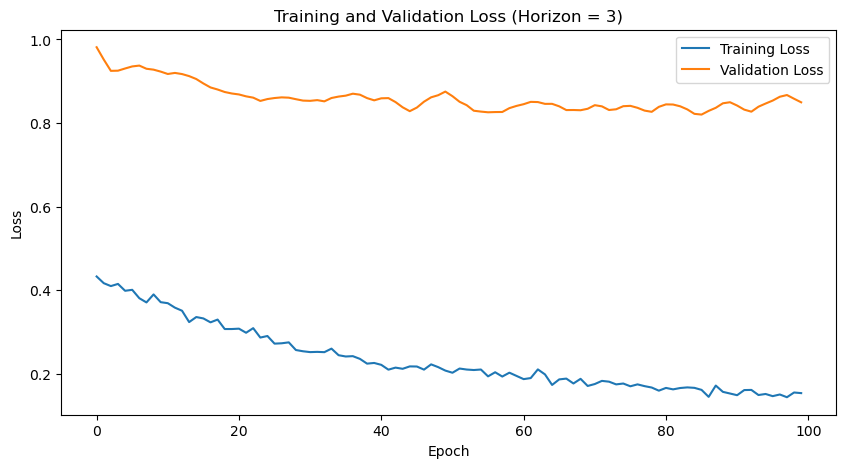

In [221]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training and Validation Loss (Horizon = {horizon})")
plt.legend()
plt.show()

In [222]:
# Evaluate on test set
test_predictions, test_targets = tf.test_model(model, test_loader, device)

# For inverse transform, we need data in [n_samples, n_features] format
# The data is already in this shape after collection from the DataLoader
# Print shapes to verify dimensions
print(f"test_predictions shape: {test_predictions.shape}")
print(f"test_targets shape: {test_targets.shape}")

# Inverse standardization
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
test_targets_rescaled = scaler.inverse_transform(test_targets)

test_predictions shape: (174, 3)
test_targets shape: (174, 3)


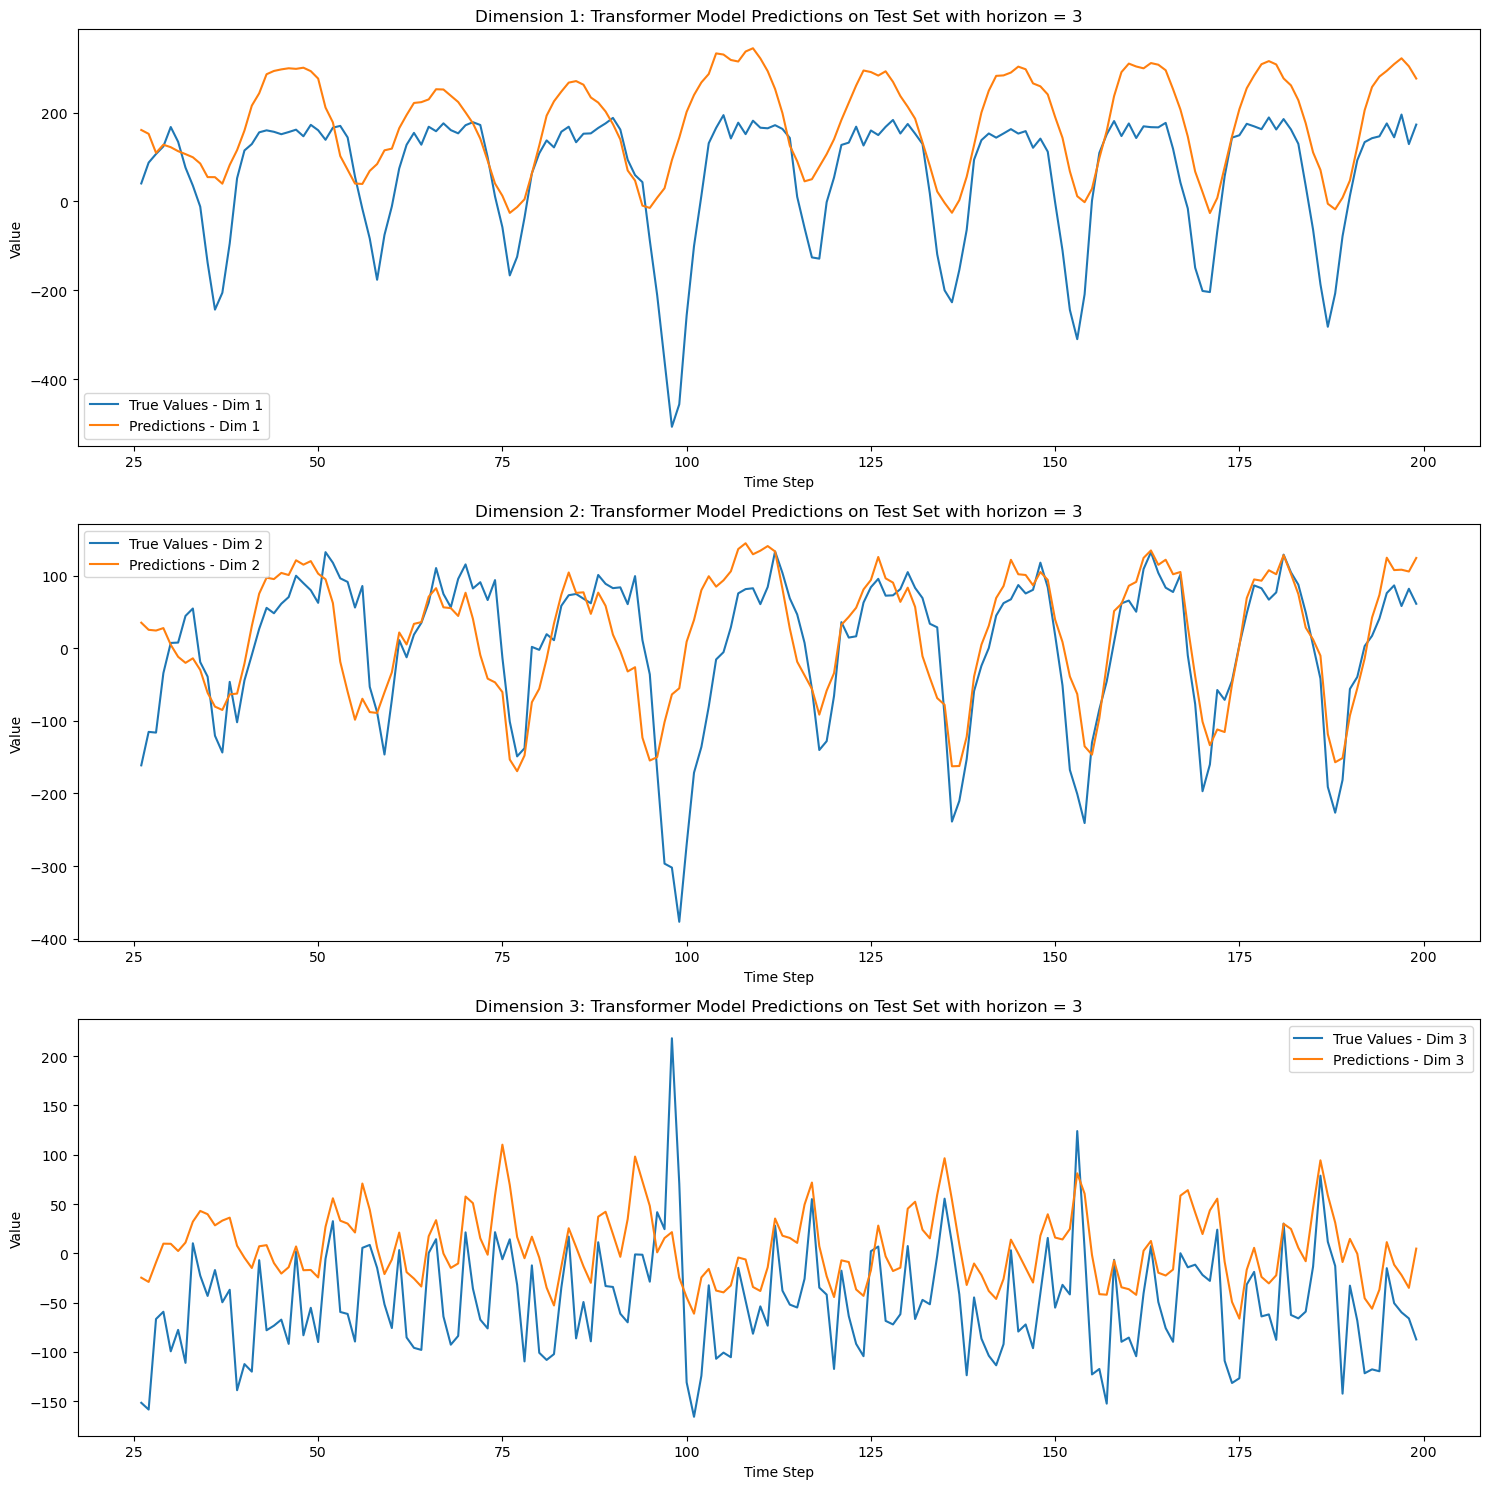

In [223]:
# Plot test predictions for each dimension
plt.figure(figsize=(15, 5 * n_features))
for i in range(n_features):
    plt.subplot(n_features, 1, i + 1)
    plt.plot(test_indices, test_targets_rescaled[:, i], label=f"True Values - Dim {i+1}")
    plt.plot(test_indices, test_predictions_rescaled[:, i], label=f"Predictions - Dim {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Dimension {i+1}: Transformer Model Predictions on Test Set with horizon = {horizon}")
    plt.legend()
plt.tight_layout()
plt.show()

In [224]:
# Calculate overall metrics across all dimensions
overall_mse = np.mean((test_predictions_rescaled - test_targets_rescaled) ** 2)
overall_rmse = np.sqrt(overall_mse)
overall_mae = np.mean(np.abs(test_predictions_rescaled - test_targets_rescaled))

print(f"Overall performance metrics for horizon = {horizon}:")
print(f"Test MSE: {overall_mse:.4f}, RMSE: {overall_rmse:.4f}, MAE: {overall_mae:.4f}")

Overall performance metrics for horizon = 3:
Test MSE: 11053.2793, RMSE: 105.1346, MAE: 77.2236
